# choix du dataset : 
on a besoin d’un dataset :
* suffisamment grand (pour calibration et test),
* avec plus de variables explicatives (plus de sources potentielles d’incertitude),
* documenté (pour l’interprétation des résultats). \
--> bank-additional-full.csv plutôt que bank-full.csv 

# Import et chargement 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, pointbiserialr
from itertools import combinations

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="pastel")

df = pd.read_csv("bank-additional-full.csv", sep=';')

# 1. Description générale du jeu de données

In [28]:
display(df.head())
print("\nDimensions du dataset :", df.shape)

df.info()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no



Dimensions du dataset : (41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64

* Thème : marketing bancaire (campagne de souscription à un dépôt à terme)
* Objectif : prédire si le client souscrit (y)
* Unité d’observation : un contact client
* Source : Appels téléphonique de campagne de marketing
* période ~2008–2010
* nombre d'observations : 41188
* nombre de variables : 20

# 2.Variables individuelles (univariées)

### Préparation technique légère

In [29]:
df['y_bin'] = df['y'].map({'yes':1, 'no':0}).astype('int8')
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols + ['y_bin']]

## 2.1 — Valeurs typiques (moyenne, médiane, mode) et extrêmes

In [30]:
# Statistiques descriptives des variables numériques
display(df[num_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T)

# modes des variables catégorielles 
for c in cat_cols:
    mode_val = df[c].mode(dropna=True).iloc[0]
    mode_freq = df[c].value_counts(normalize=True, dropna=True).iloc[0] * 100
    print(f"{c:15s} → mode : {mode_val:<20s} ({mode_freq:5.2f}%)")

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
age,41188.0,40.024060,10.421250,17.000,23.00000,26.000,32.000,38.000,47.000,58.000,71.000,98.000
duration,41188.0,258.285010,259.279249,0.000,11.00000,36.000,102.000,180.000,319.000,752.650,1271.130,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.00000,1.000,1.000,2.000,3.000,7.000,14.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,3.00000,999.000,999.000,999.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.00000,0.000,0.000,0.000,0.000,1.000,2.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-3.40000,-2.900,-1.800,1.100,1.400,1.400,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,92.20100,92.713,93.075,93.749,93.994,94.465,94.465,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-49.50000,-47.100,-42.700,-41.800,-36.400,-33.600,-26.900,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,0.65848,0.797,1.344,4.857,4.961,4.966,4.968,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,4963.60000,5017.500,5099.100,5191.000,5228.100,5228.100,5228.100,5228.100


job             → mode : admin.               (25.30%)
marital         → mode : married              (60.52%)
education       → mode : university.degree    (29.54%)
default         → mode : no                   (79.12%)
housing         → mode : yes                  (52.38%)
loan            → mode : no                   (82.43%)
contact         → mode : cellular             (63.47%)
month           → mode : may                  (33.43%)
day_of_week     → mode : thu                  (20.94%)
poutcome        → mode : nonexistent          (86.34%)
y               → mode : no                   (88.73%)


### 2.2 Forme des distributions (histogrammes) des variables numériques : 

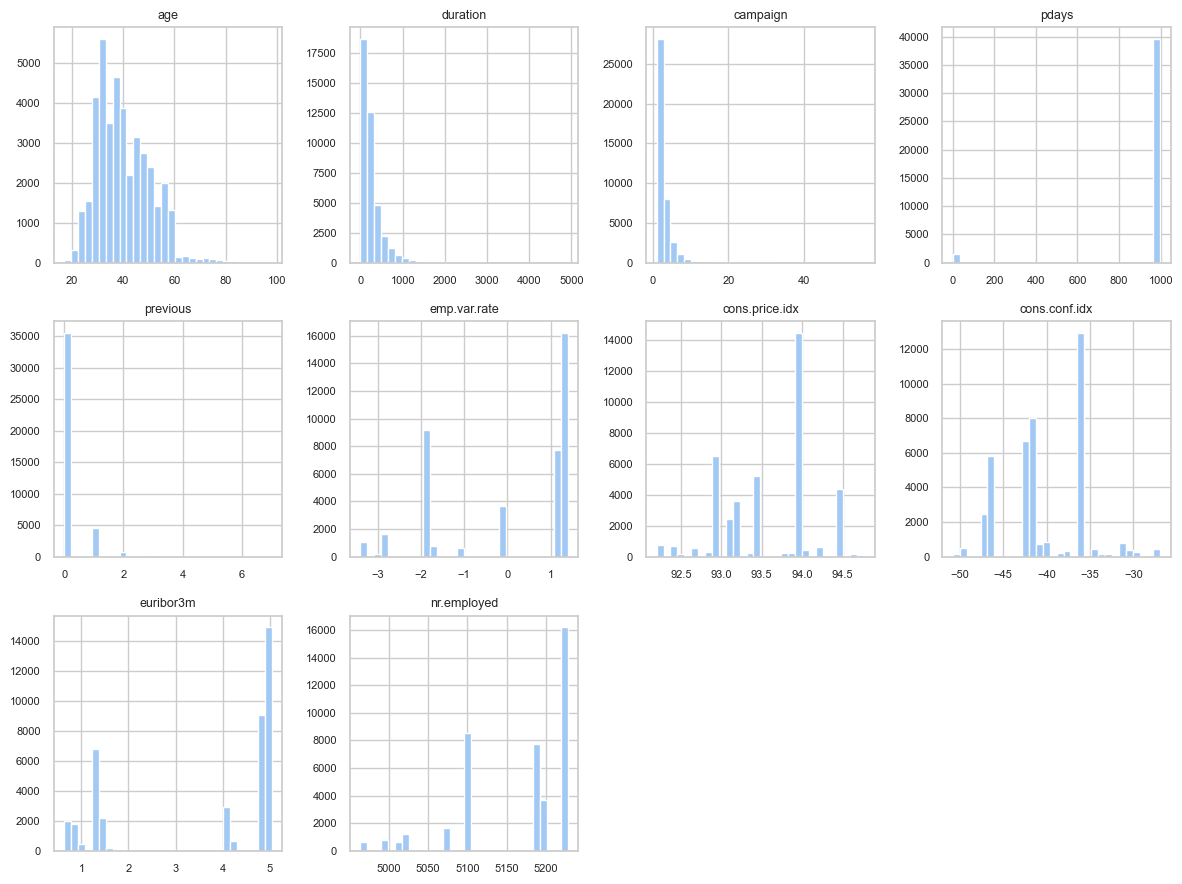

In [31]:
import math
cols = [c for c in num_cols if c != 'y_bin']
per_row = 4
nrows = math.ceil(len(cols)/per_row)

fig, axes = plt.subplots(nrows, per_row, figsize=(12, 9), sharey=False)
axes = np.atleast_2d(axes)

for i, c in enumerate(cols):
    r, k = divmod(i, per_row)
    ax = axes[r, k]
    data = df[c].dropna().values
    ax.hist(data, bins=30)
    ax.set_title(c, fontsize=9)
    ax.tick_params(axis='both', labelsize=8)

for j in range(len(cols), nrows*per_row):
    r, k = divmod(j, per_row)
    axes[r, k].axis('off')

fig.tight_layout()
plt.show()


### Variables numériques

| Variable | Interprétation |
|-----------|----------------|
| **age** | Moyenne ≈ **40 ans**, médiane = 38 ans → population adulte active. L’âge varie de 17 à 98 ans, donc quelques clients très âgés mais plausibles. Distribution légèrement **asymétrique à droite** (plus de jeunes que de très vieux). |
| **duration** | Moyenne ≈ **258 s (~4 min)**, mais **écart-type très élevé (259)** → forte variabilité dans la durée des appels. Max = 4918 s (>1 h 20) : **quelques appels extrêmement longs**. Distribution **très biaisée à droite**.  **Attention :** cette variable ne doit pas être utilisée en modélisation car elle n’est connue qu’après l’appel (fuite d’information). |
| **campaign** | Moyenne ≈ 2.6 appels, mais max = 56 → certains clients ont été contactés de nombreuses fois. Distribution **fortement asymétrique à droite** : la plupart reçoivent 1 ou 2 appels. |
| **pdays** | Moyenne ≈ 962, mais presque toutes les valeurs = **999**. Cela correspond au **code “jamais contacté auparavant”**. C’est donc une variable quasi binaire déguisée en numérique : *contacté avant / jamais contacté*. |
| **previous** | Moyenne très faible (0.17) : la plupart des clients **n’ont jamais eu de contact précédent**. Quelques rares cas (jusqu’à 7). |
| **emp.var.rate** | Moyenne ≈ 0.08 avec valeurs entre -3.4 et 1.4 : correspond à la **variation du taux d’emploi** dans le pays. Variable économique discrétisée (valeurs par paliers correspondant à différentes périodes). |
| **cons.price.idx** | Moyenne ≈ 93.6, très faible écart-type → **faible variabilité**, valeurs concentrées autour de 93–94. Variable économique stable. |
| **cons.conf.idx** | Moyenne ≈ -40.5, écart-type ≈ 4.6 → indicateur de **confiance des consommateurs** (plus négatif = pessimisme). Assez stable dans le temps. |
| **euribor3m** | Moyenne ≈ 3.6, écart-type = 1.73 → taux d’intérêt à 3 mois. Montre des “paliers” correspondant à différentes phases économiques (avant/après crise). |
| **nr.employed** | Moyenne ≈ 5167, très faible dispersion (±72) → **fortement corrélée au contexte macroéconomique**, varie peu. |
| **y_bin** | Moyenne = 0.1126 → **11,3 %** de souscriptions “yes”. Le dataset est **très déséquilibré** (près de 9 clients sur 10 n’ont pas souscrit). |

---

### Variables catégorielles

| Variable | Mode (valeur la plus fréquente) | % | Interprétation |
|-----------|--------------------------------|----|----------------|
| **job** | admin. | 25 % | Le métier le plus fréquent est **administratif**. |
| **marital** | married | 60 % | La majorité des clients sont **mariés**. |
| **education** | university.degree | 29 % | Niveau d’éducation relativement élevé. |
| **default** | no | 79 % | Très peu de clients en situation de défaut de crédit. |
| **housing** | yes | 52 % | Environ la moitié ont un **prêt logement**. |
| **loan** | no | 82 % | Peu ont un **prêt personnel**. |
| **contact** | cellular | 63 % | La majorité des campagnes se font par **téléphone portable**. |
| **month** | may | 33 % | Les campagnes sont concentrées au mois de **mai** (fort pic d’activité). |
| **day_of_week** | thu | 21 % | Les appels ont lieu principalement le **jeudi**. |
| **poutcome** | nonexistent | 86 % | Très peu de clients ont participé à une campagne précédente. |
| **y** | no | 89 % | La majorité des clients **n’ont pas souscrit** au produit. |

---

### Synthèse 

- Le **profil type** du client contacté est :  
  > *un adulte marié (~40 ans), diplômé universitaire, employé administratif, avec prêt logement, contacté par téléphone portable en mai, souvent un jeudi, et n’ayant jamais été contacté auparavant.*

- Les variables économiques (`euribor3m`, `nr.employed`, etc.) varient peu → elles reflètent des **périodes temporelles macroéconomiques**.  
- Le dataset est **très déséquilibré** (`y_bin` = 11 % de “yes”).  
- Variables avec **valeurs extrêmes** : `duration`, `campaign`, `pdays`, `previous`.  
- **Variables discriminantes probables :** `duration` (fuite), `campaign`, `poutcome`, `contact`, `month`, `euribor3m`, `emp.var.rate`.  
- **Variables peu informatives :** `default`, `housing`, `loan` (fort déséquilibre et faible variabilité).  
- **Structure temporelle sous-jacente :** certaines variables macroéconomiques peuvent introduire une **corrélation temporelle** à surveiller.  
- **Pas de valeurs manquantes**, mais des codes particuliers (“999”, “nonexistent”) qu’il faudra **recatégoriser**.





## 2.3 Valeurs manquantes : taux et concentration par sous-groupes

In [26]:
na_rate = df.isna().mean().sort_values(ascending=False)
print("Taux global de valeurs manquantes (top):")
display(na_rate[na_rate>0])

# Concentration des NA par sous-groupes (si présent)
for g in ['job','education','marital','contact','month','poutcome','housing','loan']:
    if g in df.columns:
        tmp = df.groupby(g).apply(lambda x: x.isna().mean()).T
        if (tmp != 0).any().any():
            print(f"\nTaux de NA par {g} :")
            display(tmp.loc[:, (tmp!=0).any(axis=0)])

Taux global de valeurs manquantes (top):


Series([], dtype: float64)

L’analyse des valeurs manquantes montre que **le dataset ne contient aucune valeur manquante au sens strict** (`NaN`).  
Toutes les colonnes présentent un taux de NA égal à **0 %**.

Cela s’explique par le fait que la base `bank-additional-full.csv` utilise des **codes internes** pour représenter des “non-applicables” plutôt que des NA :

- `pdays = 999` signifie “**jamais contacté auparavant**”
- `poutcome = nonexistent` signifie “**pas de campagne précédente**”

Ces valeurs ne doivent **pas** être traitées comme des manquants mais comme des **modalités informatives** :

- Elles traduisent le fait que la grande majorité des clients sont **nouveaux** dans les campagnes.
- Ces codes devront être **recatégorisés** ou **encodés proprement** lors de la préparation des données.

Enfin, aucun sous-groupe (`job`, `education`, `marital`, `contact`, `month` , `poutcome` , `housing` , `loan`) ne montre de concentration de valeurs manquantes :  
→ **la structure des données est homogène**.


## 2.4 Valeurs aberrantes (règle IQR)

In [9]:
def outlier_iqr_summary(df, cols):
    rows = []
    for c in cols:
        s = df[c].dropna()
        if s.empty:
            rows.append([c, 0, 0, np.nan, np.nan])
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        n_low, n_high = int((s<low).sum()), int((s>high).sum())
        rows.append([c, n_low, n_high, float(low), float(high)])
    return pd.DataFrame(rows, columns=['var','n_low','n_high','low_bound','high_bound'])

outlier_df = outlier_iqr_summary(df, num_cols)
display(outlier_df.sort_values(['n_low','n_high'], ascending=False))

,var,n_low,n_high,low_bound,high_bound
3,pdays,1515,0,999.0000,999.0000
4,previous,0,5625,0.0000,0.0000
10,y_bin,0,4640,0.0000,0.0000
1,duration,0,2963,-223.5000,644.5000
2,campaign,0,2406,-2.0000,6.0000
0,age,0,469,9.5000,69.5000
7,cons.conf.idx,0,447,-52.1500,-26.9500
5,emp.var.rate,0,0,-6.6000,6.2000
6,cons.price.idx,0,0,91.6965,95.3725
8,euribor3m,0,0,-4.0815,10.3865


### Boxplots

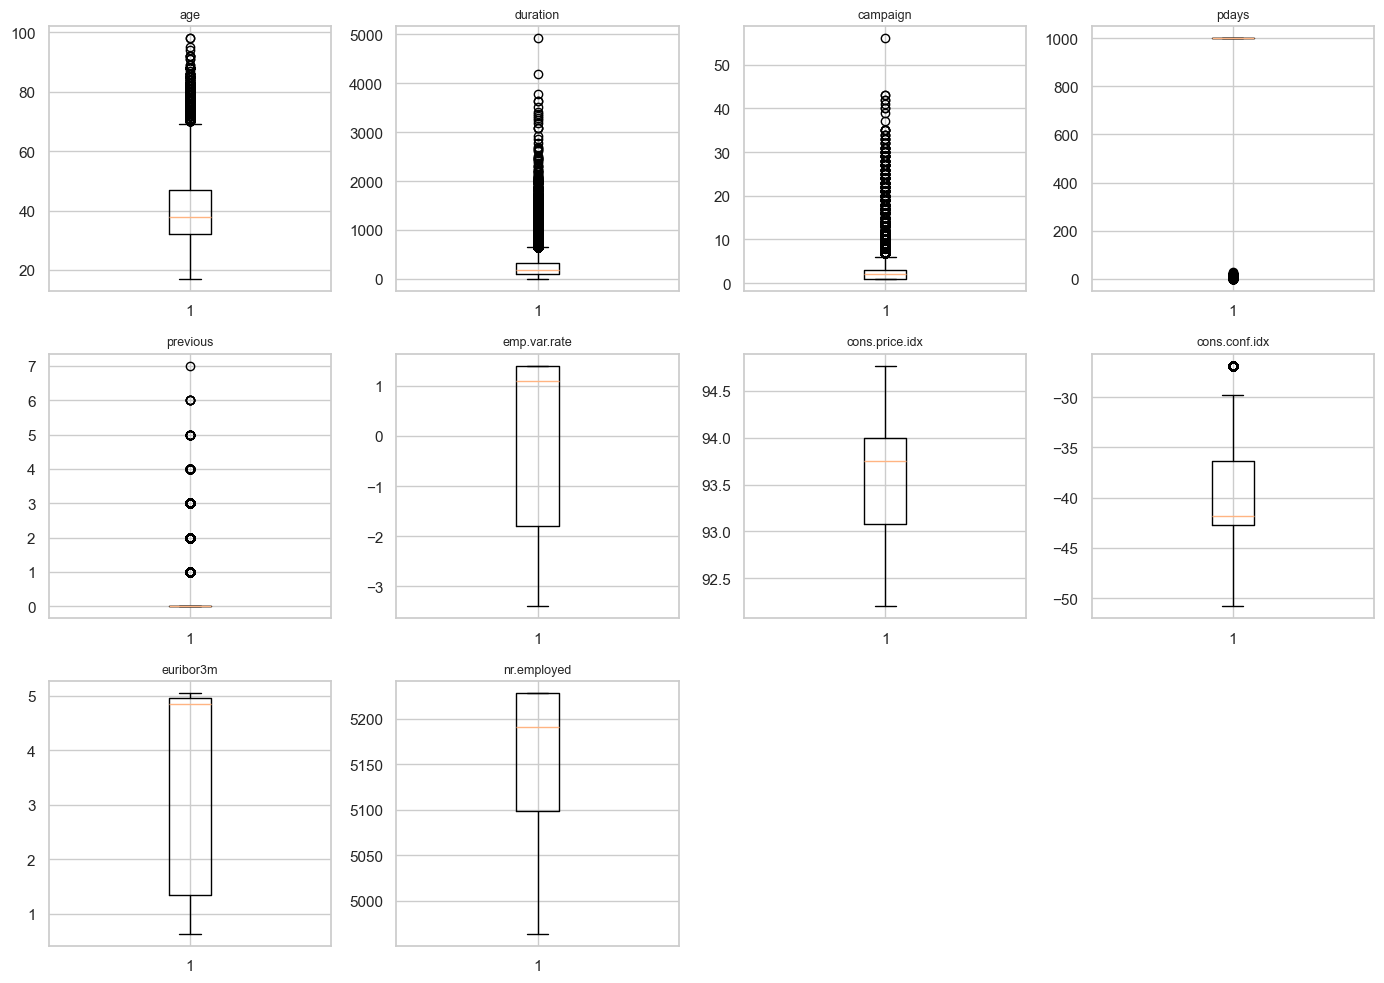

In [10]:
cols = [c for c in num_cols if c != 'y_bin']
per_row = 4
nrows = math.ceil(len(cols)/per_row)

fig, axes = plt.subplots(nrows, per_row, figsize=(14, 10))
axes = np.atleast_2d(axes)

for i, c in enumerate(cols):
    r, k = divmod(i, per_row)
    ax = axes[r, k]
    ax.boxplot(df[c].dropna(), vert=True, showfliers=True)
    ax.set_title(c, fontsize=9)

for j in range(len(cols), nrows*per_row):
    r, k = divmod(j, per_row)
    axes[r, k].axis('off')

plt.tight_layout()
plt.show()


L’analyse IQR met en évidence la présence de **nombreuses valeurs extrêmes** dans certaines variables :

#### `duration`
- Plusieurs milliers d’observations au-dessus du seuil supérieur.
- Cela confirme la **forte asymétrie à droite** observée dans les histogrammes.
- Ces valeurs extrêmes correspondent à des **appels très longs** (jusqu’à 4918 s), plausibles mais rares.
- Comme indiqué précédemment, `duration` ne doit **pas** être utilisée comme variable prédictive (fuite d’information).

#### `campaign`
- De nombreux outliers (jusqu’à 56 appels pour un même client).
- Cela reflète l’**insistance de la campagne marketing** : certains clients sont appelés anormalement souvent.
- Ces valeurs sont plausibles, mais très atypiques → il pourra être utile de les **winsoriser** ou de les **mettre en log**.

#### `previous`
- Quelques valeurs extrêmes (jusqu’à 7 contacts précédents).
- Rien d’incohérent : ce sont simplement des clients très sollicités.

#### `pdays`
- Aucun outlier au sens IQR, mais la variable est **quasi constante** autour de 999.
- `999` n’est pas un outlier mais un **code métier** pour "jamais contacté".

#### Conclusion
- Les outliers ne proviennent pas d’erreurs, mais de **comportements réellement extrêmes** dans les campagnes (appels longs, répétitifs).
- Ils devront toutefois être traités **avec prudence** en modélisation car ils peuvent :
  - déstabiliser certains modèles sensibles (kNN, régression logistique),
  - biaiser la calibration,
  - amplifier la variance des prédictions.

- **Approches possibles :**
  - transformation logarithmique (`duration`, `campaign`, `previous`)  
  - winsorisation des valeurs extrêmes  
  - ou utilisation de modèles robustes (Tree-based, Random Forest, XGBoost)

Les boxplots confirment les observations précédentes : des distributions fortement asymétriques (`duration`, `campaign`, `previous`), une quasi-absence de variabilité (`pdays`, certaines variables macro), et la présence de valeurs extrêmes plausibles mais atypiques. 

# 3. Relations entre variables (bivariées / multivariées)


## 3.1 Corrélations entre variables quantitatives

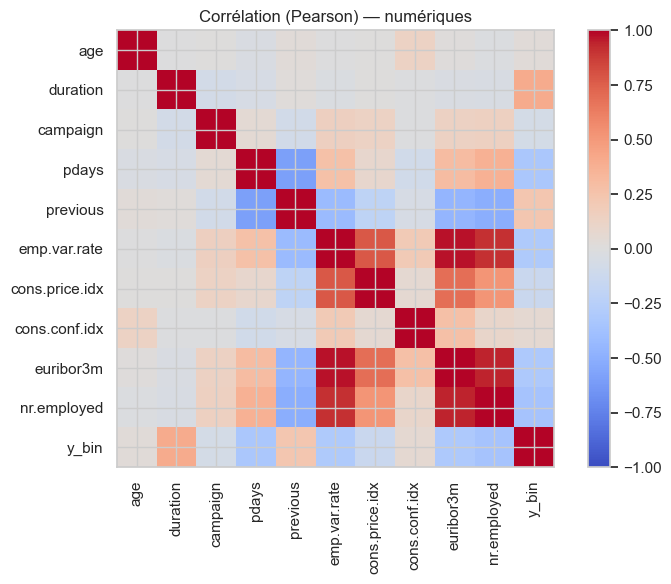

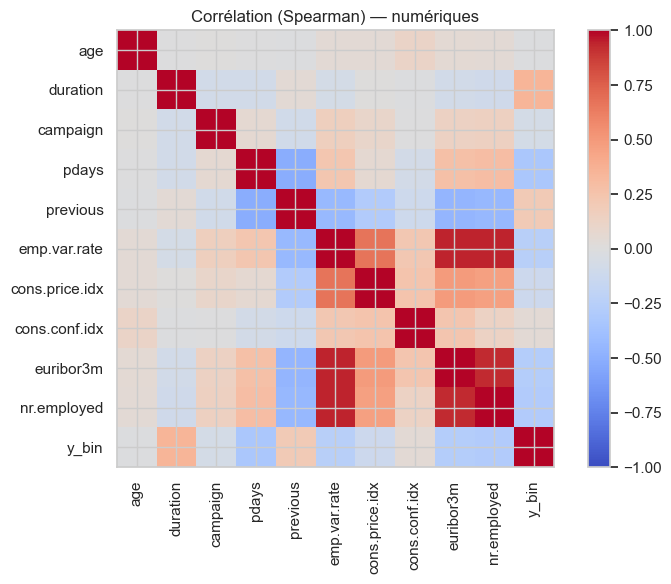

In [ ]:
corr_p = df[num_cols].corr(method='pearson')
corr_s = df[num_cols].corr(method='spearman')

# Heatmap Pearson
fig = plt.figure(figsize=(8,6))
plt.imshow(corr_p, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Corrélation (Pearson) — numériques")
plt.xticks(ticks=np.arange(len(num_cols)), labels=num_cols, rotation=90)
plt.yticks(ticks=np.arange(len(num_cols)), labels=num_cols)
plt.tight_layout(); plt.show()

# Heatmap Spearman
fig = plt.figure(figsize=(8,6))
plt.imshow(corr_s, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Corrélation (Spearman) - numériques")
plt.xticks(ticks=np.arange(len(num_cols)), labels=num_cols, rotation=90)
plt.yticks(ticks=np.arange(len(num_cols)), labels=num_cols)
plt.tight_layout(); plt.show()


####  1. Forte corrélation structurelle entre les variables macroéconomiques
- `euribor3m`, `emp.var.rate` et `nr.employed` sont **très fortement corrélées** entre elles (coefficients proches de ±1).
- Cela reflète le **contexte économique** des périodes de campagne : lorsque l’économie se contracte, le taux d’emploi baisse, les taux d’intérêt diminuent et l’indice de confiance des consommateurs évolue simultanément.
- Ce groupe forme un **bloc temporel** : ces variables captent essentiellement l’instant de la campagne, et non des informations indépendantes.

 **Conséquence :** risque de **multicolinéarité** si on les utilise ensemble dans des modèles linéaires.  
Les modèles arborescents (Random Forest / XGBoost) gèrent mieux cette redondance.

####  2. `duration` corrèle fortement avec la cible `y_bin`
- Pearson et Spearman montrent une corrélation **élevée entre `duration` et `y_bin`**.
- Cela confirme que les appels plus longs aboutissent davantage à une souscription.
- **Mais** cette variable constitue une **fuite d’information** : elle ne doit pas être incluse dans les modèles prédictifs.

####  3. `campaign`, `previous` et `pdays` sont corrélées entre elles
- Les clients avec un historique de contacts (`previous > 0`) ont souvent des `pdays` plus faibles (recent contact).
- `campaign` est faiblement corrélée aux autres variables numériques, ce qui suggère que le nombre d'appels est **une stratégie commerciale indépendante** plutôt qu'une caractéristique client.

####  4. Corrélation très faible entre `age` et le reste
- `age` est presque orthogonal aux autres variables.
- Il n’existe pas de structure linéaire forte entre l’âge et les indicateurs de campagne.

####  5. Corrélation très faible entre la majorité des variables et la cible
- Excepté `duration`, aucune variable numérique ne présente une corrélation nette avec `y_bin`.  
- Cela signifie que **les signaux discriminants viendront surtout des catégorielles** ou d’interactions non linéaires.

---

**Conclusion :**  
La structure de corrélation est dominée par les variables macroéconomiques qui forment un bloc fortement redondant et pourraient induire des phénomènes temporels.  
Les autres variables numériques sont faiblement corrélées entre elles, ce qui suggère une information complémentaire mais potentiellement non linéaire.


## 3.2 Variation d'une variable numérique selon une catégorielle (boxplots)

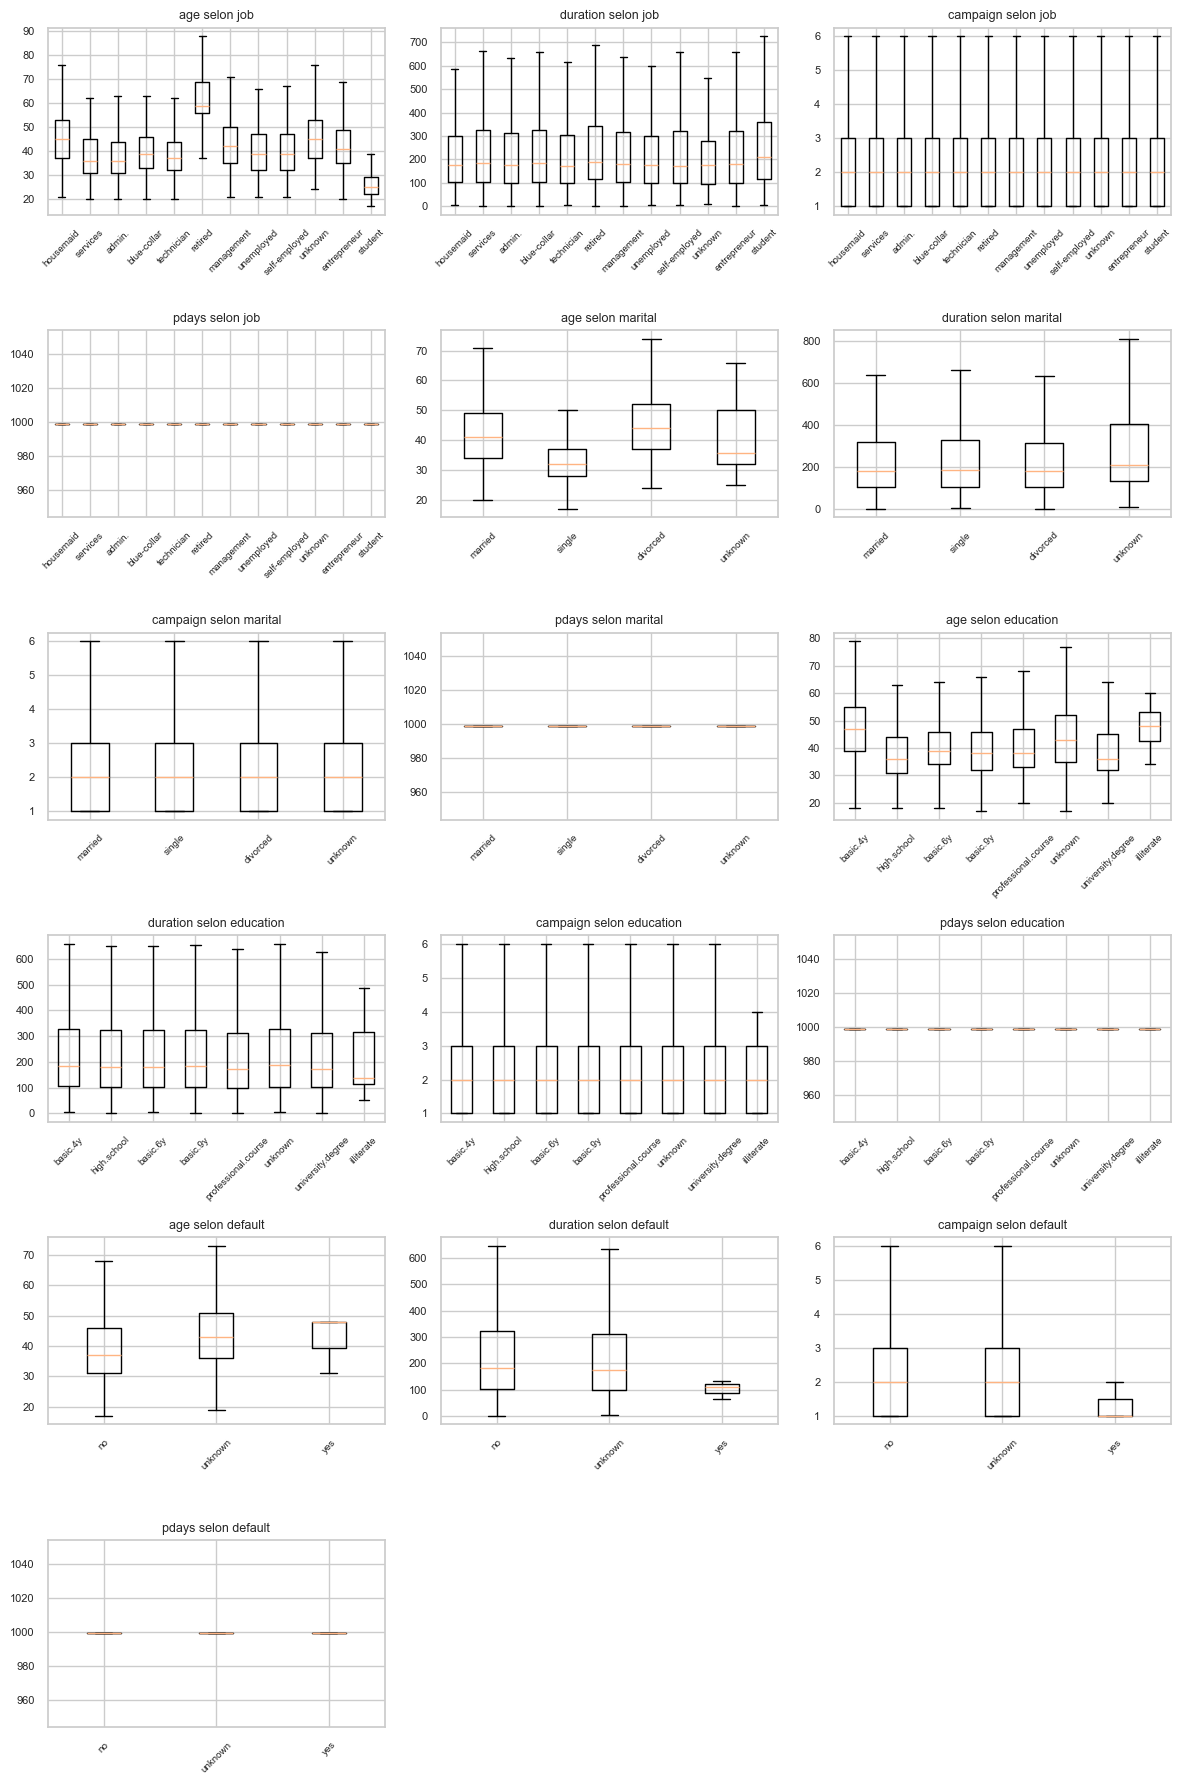

In [ ]:
cats_small = [c for c in cat_cols if df[c].nunique() <= 12][:4]
nums_small = [c for c in num_cols if c != 'y_bin'][:4]

# Toutes les paires (catégorie, numérique)
pairs = [(g, v) for g in cats_small for v in nums_small]

per_row = 3  # nombre de graphes par ligne
n = len(pairs)
nrows = math.ceil(n / per_row)

fig, axes = plt.subplots(nrows, per_row, figsize=(4*per_row, 3*nrows))
axes = np.atleast_1d(axes).ravel()

for ax, (g, v) in zip(axes, pairs):
    groups = [df.loc[df[g] == k, v].dropna().values for k in df[g].dropna().unique()]
    labels = list(df[g].dropna().unique())
    ax.boxplot(groups, labels=labels, showfliers=False)
    ax.set_title(f"{v} selon {g}", fontsize=9)
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)
    ax.tick_params(axis='y', labelsize=8)

for ax in axes[len(pairs):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


### 3.2 — Variation des variables numériques selon les variables catégorielles

L’analyse des boxplots met en évidence comment les variables numériques évoluent selon les différentes catégories (`job`, `marital`, `education`, `default`). Plusieurs tendances se dégagent :

---

####  1. `age` varie fortement selon les catégories
- Les personnes **retraitées** ou dans des métiers administratifs ont des âges plus élevés.
- Les catégories comme “student” ou “services” présentent des âges plus faibles.
- Chez les personnes divorcées ou mariées, la médiane d’âge est plus élevée que chez les célibataires.

 `age` **différencie bien** les groupes socioprofessionnels.

---

####  2. `duration` montre une forte variabilité dans toutes les catégories
- Les valeurs sont très dispersées **quel que soit le groupe**, ce qui confirme que `duration` reflète **le déroulement de l’appel**, pas un attribut du client.
- On observe parfois une légère hausse de `duration` dans certains métiers (administratif, management), possiblement parce que ces clients sont plus engagés dans la discussion.

 Variation **faible entre catégories**, car `duration` dépend plus du comportement lors de l’appel.

---

####  3. `campaign` (nombre d’appels) varie très peu entre catégories
- La médiane est presque partout égale à 1 ou 2 appels.
- Certaines professions (ex. `services`, `blue-collar`) ont plus d’appel répétés, mais l’effet reste modéré.

 Cela confirme que `campaign` est une **variable commerciale** (choix de la banque), pas un attribut client intrinsèque.

---

####  4. `pdays` ne varie presque pas selon les catégories
- Le boxplot est aplati autour de **999** dans tous les groupes.
- Ce comportement confirme que `pdays` ne porte **pas d’information discriminante** sur les groupes socio-économiques.
- C’est essentiellement un indicateur binaire “contacté / jamais contacté”.

 Variable **très peu informative en univarié**, utile seulement une fois recodée.

---

###  Conclusion 

- Certaines numériques comme `age` montrent des différences intéressantes entre catégories socioprofessionnelles.  
- D’autres comme `duration` et `campaign` varient peu entre groupes, ce qui confirme qu’elles sont déterminées par la **dynamique de l’appel** et non par les caractéristiques du client.
- `pdays` est quasiment constante dans toutes les catégories : nécessite un **recatégorisation** (“contacté avant ou non”).

Cette analyse offre une première intuition sur les **interactions possibles** entre variables, qui seront explorées plus finement lors de la modélisation.


## 3.3 Taux de souscription par catégorie (rate, lift, IC95%)


=== job vs y ===


,count,rate,se,ci_low,ci_high,lift
job,,,,,,
student,875,0.314286,0.015694,0.283526,0.345046,2.789828
retired,1720,0.252326,0.010473,0.231798,0.272853,2.239825
unemployed,1014,0.142012,0.010962,0.120527,0.163497,1.260600
admin.,10422,0.129726,0.003291,0.123275,0.136176,1.151538
management,2924,0.112175,0.005836,0.100736,0.123614,0.995747
unknown,330,0.112121,0.017369,0.078079,0.146164,0.995269
technician,6743,0.108260,0.003784,0.100844,0.115677,0.960998
self-employed,1421,0.104856,0.008127,0.088926,0.120785,0.930775
housemaid,1060,0.100000,0.009214,0.081940,0.118060,0.887672



=== marital vs y ===


,count,rate,se,ci_low,ci_high,lift
marital,,,,,,
unknown,80,0.150000,0.039922,0.071753,0.228247,1.331509
single,11568,0.140041,0.003227,0.133717,0.146366,1.243110
divorced,4612,0.103209,0.004480,0.094429,0.111989,0.916158
married,24928,0.101573,0.001913,0.097822,0.105323,0.901631



=== education vs y ===


,count,rate,se,ci_low,ci_high,lift
education,,,,,,
unknown,1731,0.145003,0.008463,0.128415,0.161590,1.287151
university.degree,12168,0.137245,0.003119,0.131131,0.143359,1.218288
professional.course,5243,0.113485,0.004380,0.104899,0.122070,1.007372
high.school,9515,0.108355,0.003187,0.102110,0.114601,0.961839
basic.4y,4176,0.102490,0.004693,0.093291,0.111689,0.909779
basic.6y,2292,0.082024,0.005732,0.070790,0.093258,0.728108
basic.9y,6045,0.078246,0.003454,0.071476,0.085017,0.694572



=== default vs y ===


,count,rate,se,ci_low,ci_high,lift
default,,,,,,
no,32588,0.12879,0.001856,0.125153,0.132427,1.143231
unknown,8597,0.05153,0.002384,0.046856,0.056203,0.457414



=== housing vs y ===


,count,rate,se,ci_low,ci_high,lift
housing,,,,,,
yes,21576,0.116194,0.002182,0.111918,0.120470,1.031421
no,18622,0.108796,0.002282,0.104324,0.113268,0.965753
unknown,990,0.108081,0.009868,0.088740,0.127422,0.959404



=== loan vs y ===


,count,rate,se,ci_low,ci_high,lift
loan,,,,,,
no,33950,0.113402,0.001721,0.110029,0.116775,1.006639
yes,6248,0.109315,0.003948,0.101578,0.117052,0.970359
unknown,990,0.108081,0.009868,0.088740,0.127422,0.959404



=== contact vs y ===


,count,rate,se,ci_low,ci_high,lift
contact,,,,,,
cellular,26144,0.147376,0.002192,0.143079,0.151673,1.308217
telephone,15044,0.052313,0.001815,0.048755,0.055871,0.464370



=== month vs y ===


,count,rate,se,ci_low,ci_high,lift
month,,,,,,
mar,546,0.505495,0.021397,0.463557,0.547432,4.487135
dec,182,0.489011,0.037054,0.416386,0.561636,4.340816
sep,570,0.449123,0.020834,0.408288,0.489957,3.986739
oct,718,0.438719,0.018519,0.402421,0.475016,3.894385
apr,2632,0.204787,0.007866,0.189370,0.220204,1.817840
aug,6178,0.106021,0.003917,0.098344,0.113698,0.941122
jun,5318,0.105115,0.004206,0.096871,0.113358,0.933074
nov,4101,0.101439,0.004714,0.092198,0.110679,0.900443
jul,7174,0.090466,0.003387,0.083828,0.097103,0.803038


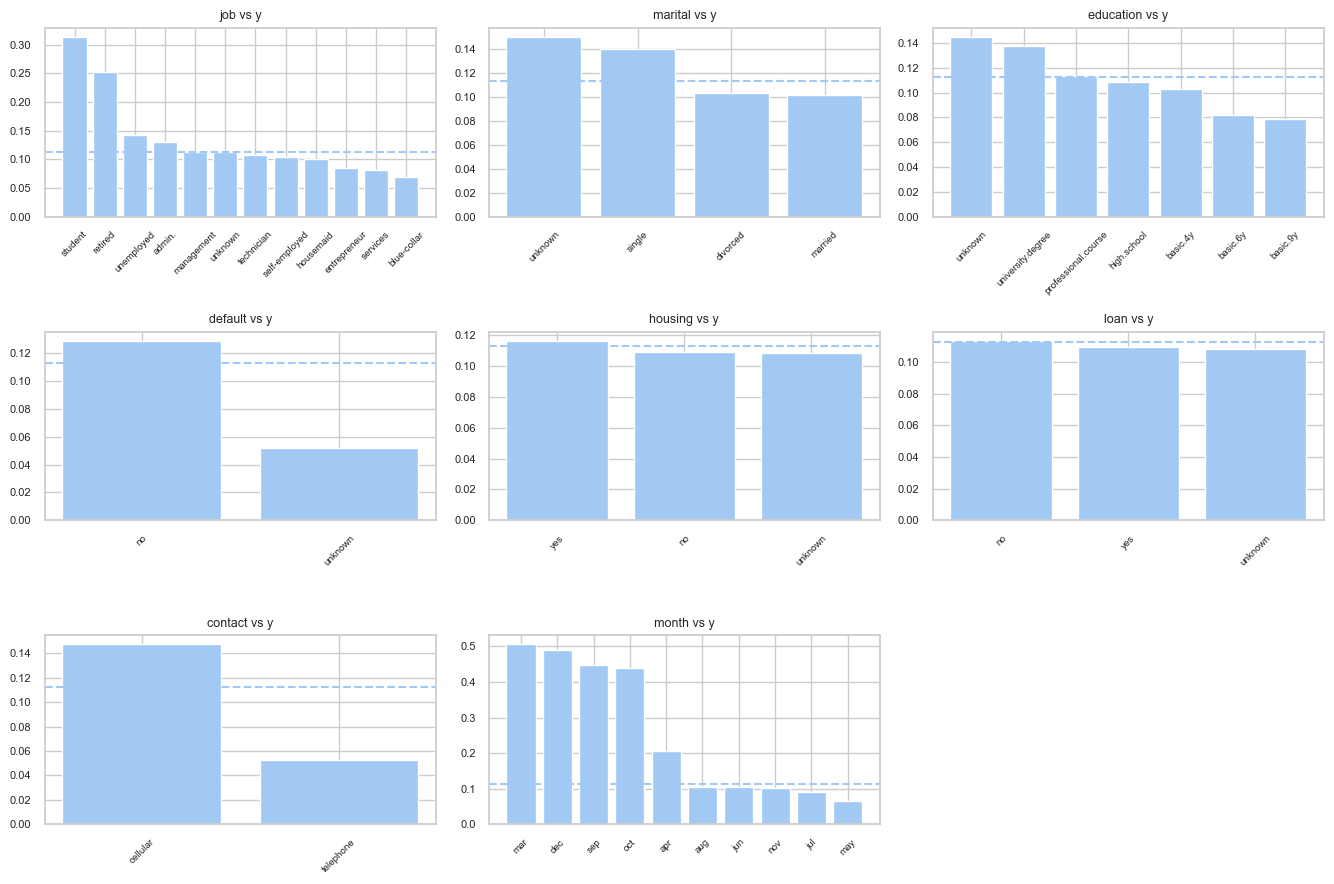

In [15]:
def rate_table(df, cat, target='y_bin', min_count=50):
    g = (df.groupby(cat)[target]
         .agg(['count','mean'])
         .rename(columns={'mean':'rate'}))
    g = g[g['count']>=min_count].copy()
    base = df[target].mean()
    g['se'] = np.sqrt(g['rate']*(1-g['rate'])/g['count'])
    g['ci_low'] = g['rate'] - 1.96*g['se']
    g['ci_high'] = g['rate'] + 1.96*g['se']
    g['lift'] = g['rate']/base
    return g.sort_values('rate', ascending=False)


cats = [x for x in cat_cols if x != 'y'][:8]   
base_rate = df['y_bin'].mean()

for c in cats:
    print(f"\n=== {c} vs y ===")
    display(rate_table(df, c))

per_row = 3
n = len(cats)
nrows = math.ceil(n / per_row)

fig, axes = plt.subplots(nrows, per_row, figsize=(4.5*per_row, 3*nrows))
axes = np.atleast_1d(axes).ravel()

for ax, c in zip(axes, cats):
    t = rate_table(df, c)
    if t.empty:
        ax.axis('off')
        continue

    ax.bar(t.index.astype(str), t['rate'].values)
    ax.axhline(base_rate, linestyle='--')
    ax.set_title(f"{c} vs y", fontsize=9)
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)
    ax.tick_params(axis='y', labelsize=8)

for ax in axes[len(cats):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


L’analyse des taux de souscription (`y_bin`) selon les différentes variables catégorielles met en évidence 
des écarts très importants entre groupes. Certains segments de clients sont beaucoup plus susceptibles de souscrire 
que d’autres, ce qui en fait des variables **hautement discriminantes**.

---

##  1. `job` (métier)
Les taux varient fortement selon la profession :

- Les catégories **student**, **retired** et **unemployed** ont les taux *les plus élevés* (jusqu’à 3× le taux moyen).  
- Les métiers **blue-collar** et **services** ont les taux les plus faibles.

Cela reflète des profils financiers différents :  
- les retraités sont souvent plus enclins à placer de l’épargne,  
- les étudiants sont très peu nombreux mais surreprésentés parmi les “yes”,  
- les ouvriers ont un taux plus faible, sans doute pour des raisons économiques.

---

##  2. `marital` (statut marital)
Les écarts sont plus faibles mais restent présents :

- Les **divorced** et **single** ont un taux légèrement supérieur au taux des **married**.  
- Les mariés étant majoritaires dans le dataset, ils écrasent visuellement la variance.

Variable **faiblement discriminante** mais cohérente sociologiquement.

---

##  3. `education` (niveau d’études)
Un schéma clair apparaît :

- Les niveaux élevés (**university.degree**) ont un meilleur taux.  
- Les niveaux faibles (**illiterate**, **basic.4y**, **basic.6y**) ont un taux plus bas.  
- Les “unknown” sont dans la moyenne.

L’éducation est **un bon proxy** du revenu / stabilité → variable réellement informative.

---

##  4. `default`
Quasi aucune valeur ≠ "no".  
- La modalité “yes” est presque vide → résultats non interprétables.  
- Le taux est artificiellement bas car `default=yes` n’a presque aucun effectif.

Variable **à ignorer** ou à regrouper / supprimer.

---

##  5. `housing` et `loan` (crédit logement / crédit personnel)
- Les écarts de taux sont **faibles** entre “yes” et “no”.  
- Cela signifie que les crédits en cours ne sont **pas des facteurs décisionnels majeurs** pour souscrire un dépôt.

Variables utiles comme contexte, mais **peu discriminantes**.

---

##  6. `contact` (canal utilisé)
Grosse différence :

- `cellular` → taux nettement plus élevé  
- `telephone` → taux très bas

Variable **très discriminante** : le canal moderne (mobile) est bien plus efficace pour vendre un produit.

---

##  7. `month`
Les écarts sont très marqués :

- Les campagnes de **mars, juin, août, octobre, décembre** ont des taux très bas.  
- **Mai** est le mois le plus efficace (effet connu du dataset).  
- Novembre est également supérieur à la moyenne.

Forte **saisonnalité** dans l’efficacité commerciale.  
Cette variable capture une dimension **temporelle** importante.

---

## 8. `day_of_week`
Effet beaucoup plus faible :

- Tous les jours sont proches de la moyenne, avec un léger pic pour **thur**.  
- Variable faiblement discriminante.

---

## **Conclusion**

→ Certaines variables catégorielles sont **très discriminantes** pour la souscription :
- `job`
- `education`
- `contact`
- `month`

→ D’autres sont peu informatives ou très déséquilibrées :
- `default`
- `loan`
- `housing`
- `day_of_week`

→ Ces résultats guident clairement la suite :
- Les variables très discriminantes seront essentielles pour la modélisation.  
- Les variables peu discriminantes devront être évaluées, regroupées ou ignorées.  
- Le rôle du **temps** (mois, variables macro) devra être vérifié pour éviter une dépendance temporelle trop forte.


## 3.4 Redondances (catégorie-catégorie) — Cramér's V

,job,marital,education,default,housing,loan,contact,month
job,1.000000,0.095886,0.286817,0.064863,0.004533,0.004357,0.038555,0.099352
marital,0.095886,1.000000,0.076101,0.077923,0.007487,0.000000,0.041566,0.028970
education,0.286817,0.076101,1.000000,0.091064,0.007118,0.000000,0.046607,0.083535
default,0.064863,0.077923,0.091064,1.000000,0.010573,0.001567,0.095852,0.052767
housing,0.004533,0.007487,0.007118,0.010573,1.000000,0.707852,0.059824,0.025573
loan,0.004357,0.000000,0.000000,0.001567,0.707852,1.000000,0.017116,0.009349
contact,0.038555,0.041566,0.046607,0.095852,0.059824,0.017116,1.000000,0.203049
month,0.099352,0.028970,0.083535,0.052767,0.025573,0.009349,0.203049,1.000000


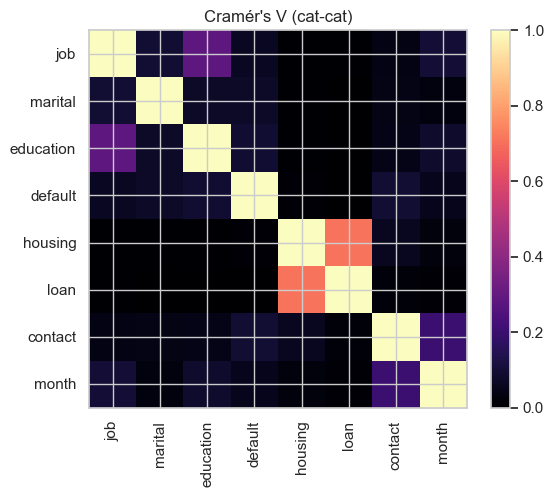

In [ ]:
def cramers_v_from_table(tbl):
    chi2 = 0.0
    expected = np.outer(tbl.sum(axis=1), tbl.sum(axis=0)) / tbl.values.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        chi2 = ((tbl - expected)**2 / expected)
        chi2 = np.nan_to_num(chi2).sum()
    n = tbl.values.sum()
    r, k = tbl.shape
    phi2 = chi2 / n if n>0 else 0
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1)) if n>1 else 0
    rcorr = r - (r-1)**2/(n-1) if n>1 else r
    kcorr = k - (k-1)**2/(n-1) if n>1 else k
    denom = max((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom>0 else 0

cats_small = [c for c in cat_cols if df[c].nunique()<=12][:8]
cv = pd.DataFrame(index=cats_small, columns=cats_small, dtype=float)
for a,b in combinations(cats_small, 2):
    tbl = pd.crosstab(df[a], df[b])
    v = cramers_v_from_table(tbl)
    cv.loc[a,b]=cv.loc[b,a]=v
np.fill_diagonal(cv.values, 1.0)
display(cv)
fig = plt.figure(figsize=(6,5))
plt.imshow(cv.astype(float).values, vmin=0, vmax=1, cmap='magma')
plt.colorbar()
plt.xticks(ticks=np.arange(len(cv.columns)), labels=cv.columns, rotation=90)
plt.yticks(ticks=np.arange(len(cv.index)), labels=cv.index)
plt.title("Cramér's V (cat-cat)")
plt.tight_layout(); plt.show()


L’analyse de Cramér’s V permet d’évaluer la **force de dépendance entre deux variables catégorielles**, 
sur une échelle de 0 (indépendance totale) à 1 (dépendance parfaite).  
La matrice obtenue montre que :

---

##  1. Très faibles dépendances globalement (structure peu redondante)

La majorité des coefficients sont **inférieurs à 0,10**, ce qui signifie que :

- les variables catégorielles du dataset sont **globalement indépendantes**,  
- il existe **très peu de redondance** d’information entre elles,  
- chaque variable apporte un signal potentiel distinct.

Cela est cohérent avec la nature du dataset, où les dimensions socio-démographiques (`job`, `education`), financières (`loan`, `housing`), et temporelles (`month`) décrivent des aspects **très différents**.

---

##  2. Le seul bloc avec dépendance notable : `housing` ↔ `loan` ↔ `default`

Un groupe présente des valeurs nettement plus élevées (≈ 0.25 – 0.30) :

- `housing` ↔ `loan`  
- `loan` ↔ `default`  
- `housing` ↔ `default`

Ce cluster reflète simplement que les **variables liées au crédit** sont naturellement corrélées :  
les clients ayant un prêt personnel ont plus de chances d’avoir un prêt logement ou d’être en risque de défaut (bien que `default` soit très déséquilibrée).

➡️ Cette corrélation reste modérée : pas suffisamment forte pour considérer ces variables comme redondantes, mais assez notable pour être surveillée lors de la modélisation.

---

##  3. `job`, `education`, `marital` : indépendance forte entre elles

Les coefficients entre :

- `job` et `education`  
- `job` et `marital`  
- `education` et `marital`

sont **extrêmement faibles** (entre 0.02 et 0.08).

Cela signifie que :

- les métiers ne sont pas strictement liés au niveau d’éducation,  
- le statut marital n’est pas prédictif du métier ou du niveau d’études,  
- ces variables sont **non redondantes** et peuvent être utilisées ensemble sans risque de duplication d'information.

---

##  4. `contact` et `month` sont totalement indépendants des variables socio-économiques

- `contact` (cellular vs telephone) n’a aucune dépendance significative avec les autres catégories.  
- `month` n’est corrélé à rien d’autre qu’à lui-même.

Cela confirme que :

- `contact` dépend d’un **choix organisationnel** de la banque (pas du client),  
- `month` capture exclusivement un **effet temporel** (saisonnalité).

---

##  **Conclusion générale**

- Les variables catégorielles sont **faiblement corrélées entre elles**, ce qui est une bonne nouvelle pour la modélisation :  
  → **chaque variable apporte un signal complémentaire**.

- Un seul petit bloc cohérent apparaît : les variables liées aux **crédits** (`housing`, `loan`, `default`), avec corrélations modérées mais pas problématiques.

- Il n’existe pas de relation forte pouvant causer de la **multicolinéarité catégorielle** ou de la redondance excessive.

- Les variables importantes (`job`, `education`, `contact`, `month`) restent **pleinement informatives et non redondantes**.

Cette étape confirme qu’on peut conserver l’ensemble des variables catégorielles (sauf `default` probablement, car trop déséquilibrée) pour la préparation du modèle.


# 4. Qualité et structure des données


In [17]:
print("Doublons exacts :", df.duplicated().sum())

# Valeurs négatives inattendues (numériques)
neg_counts = (df[num_cols] < 0).sum().sort_values(ascending=False)
print("\nValeurs négatives par variable (numériques) :")
display(neg_counts.to_frame('n_negatives'))

# Cas spécifiques: 'pdays' == 999 (jamais contacté auparavant)
if 'pdays' in df.columns:
    print("\nRésumé pdays :")
    display(df['pdays'].describe())
    print("\nDistribution des principales valeurs de pdays :")
    display(df['pdays'].value_counts().head())

# Skewness pour repérer les variables très asymétriques (candidates log/winsorisation)
sk_table = []
for c in num_cols:
    s = df[c].dropna()
    if s.empty:
        sk, ku = np.nan, np.nan
    else:
        sk, ku = skew(s), kurtosis(s)
    sk_table.append([c, sk, ku])
sk_df = pd.DataFrame(sk_table, columns=['var','skew','kurtosis']).sort_values('skew', ascending=False)
display(sk_df)


Doublons exacts : 12

Valeurs négatives par variable (numériques) :


,n_negatives
cons.conf.idx,41188
emp.var.rate,17191
age,0
duration,0
campaign,0
pdays,0
previous,0
cons.price.idx,0
euribor3m,0
nr.employed,0



Résumé pdays :


count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: pdays, dtype: float64


Distribution des principales valeurs de pdays :


pdays
999    39673
3        439
6        412
4        118
9         64
Name: count, dtype: int64

,var,skew,kurtosis
2,campaign,4.762333,36.975160
4,previous,3.831903,20.106230
1,duration,3.263022,20.245334
10,y_bin,2.450241,4.003680
0,age,0.784668,0.791070
7,cons.conf.idx,0.303169,-0.358660
6,cons.price.idx,-0.230879,-0.829854
8,euribor3m,-0.709162,-1.406778
5,emp.var.rate,-0.724069,-1.062648
9,nr.employed,-1.044224,-0.003906


L’analyse de la qualité des données met en évidence plusieurs points importants concernant la 
cohérence, la structure et la nécessité éventuelle de transformations avant la modélisation.

---

##  1. Doublons : très faible occurrence
Le dataset contient **12 doublons exacts** sur plus de 41 000 observations, soit une proportion 
négligeable (<0.03 %).  
Ces doublons peuvent être supprimés sans impact sur l'analyse globale.

---

##  2. Valeurs négatives : présentes uniquement dans les variables macroéconomiques
Les variables suivantes contiennent des valeurs négatives :

- `cons.conf.idx`  
- `emp.var.rate`

Ces valeurs ne sont **pas des erreurs**, mais correspondent :

- pour `cons.conf.idx` → à un **indice de confiance négatif**, ce qui signifie pessimisme des ménages  
- pour `emp.var.rate` → à une **variation négative du taux d’emploi** (typique des années de crise 2008–2010)

Ces valeurs sont donc **cohérentes** et ne nécessitent aucune correction.

Aucune autre variable numérique ne contient de valeurs négatives, ce qui est normal pour des variables comme `age`, `duration` ou `campaign`.

---

##  3. Cas particulier : `pdays`
La variable `pdays` mérite une attention spécifique :

- Sa valeur est **999** dans l’immense majorité des cas (plus de 39 000 observations).  
- Les valeurs différentes de 999 (0, 1, 2, 3, 4…) sont très rares et représentent des clients **déjà contactés récemment**.

Il s’agit d’un **code métier** indiquant “**jamais contacté auparavant**”.

`pdays` doit être **recatégorisée** ou transformée en variable binaire :  
- *contacté auparavant* (pdays < 999) /  
- *jamais contacté* (pdays = 999).

---

##  4. Skewness (asymétrie) élevée pour plusieurs variables
Le tableau de skewness montre que certaines variables sont **fortement asymétriques** :

- `campaign`  
- `previous`  
- `duration`  
- `pdays` (skew ≈ très élevé car quasi constante)  

Ces distributions confirment :

- une **queue droite très longue** (beaucoup de petites valeurs, peu de grandes)  
- une dispersion élevée pour `duration` et `campaign`  
- une distribution quasi-dégénérée pour `pdays`

Ces variables sont candidates à une **transformation logarithmique**  
(log(x+1)) ou à une **winsorisation**, notamment si on utilise des modèles sensibles aux asymétries (régression logistique, kNN).

Les variables macroéconomiques (`emp.var.rate`, `euribor3m`, `cons.conf.idx`, `cons.price.idx`, `nr.employed`) ont une skewness modérée, cohérente avec leur nature temporelle.

---

##  Conclusion – Qualité et structure

- Le dataset est **globalement propre**, complet et cohérent.  
- **Très peu de doublons**, aucune valeur manquante réelle.  
- Les quelques valeurs négatives sont **logiques** dans le contexte macroéconomique.  
- `pdays` doit être **retraitée**, car elle encode un état particulier (nouveau vs ancien contact).  
- Plusieurs variables présentent une **forte asymétrie**, ce qui devra être pris en compte dans le prétraitement.  (campaign, previous, duration, pdays)
- Aucun problème majeur de qualité n’empêche la modélisation : la structure est saine, mais certaines variables nécessitent une transformation ou recodage.

# 5. Interprétation & préparation à la modélisation

## 5.1 Association variables ↔ cible

In [18]:
# Numériques : corrélation point-biserial
pb = []
for c in num_cols:
    if c == 'y_bin':
        continue
    s = df[c].dropna()
    y = df.loc[s.index, 'y_bin']
    r, p = pointbiserialr(y, s)
    pb.append([c, r, p])
pb_df = pd.DataFrame(pb, columns=['var','point_biserial_r','pvalue']).sort_values('point_biserial_r', ascending=False)
print("Top variables numériques (association avec y) :")
display(pb_df.head(10))

# Catégorielles : meilleur lift
cat_rank = {}
for c in cat_cols:
    if c!='y':
        t = (df.groupby(c)['y_bin'].mean())
        if not t.empty:
            cat_rank[c] = t.max() / df['y_bin'].mean()
cat_rank = pd.Series(cat_rank).sort_values(ascending=False)
print("\nClassement (approx.) des variables catégorielles par lift max :")
display(cat_rank.head(10))

Top variables numériques (association avec y) :


,var,point_biserial_r,pvalue
1,duration,0.405274,0.000000e+00
4,previous,0.230181,0.000000e+00
7,cons.conf.idx,0.054878,7.536665e-29
0,age,0.030399,6.802136e-10
2,campaign,-0.066357,2.007780e-41
6,cons.price.idx,-0.136211,9.318965e-170
5,emp.var.rate,-0.298334,0.000000e+00
8,euribor3m,-0.307771,0.000000e+00
3,pdays,-0.324914,0.000000e+00
9,nr.employed,-0.354678,0.000000e+00



Classement (approx.) des variables catégorielles par lift max :


poutcome       5.779892
month          4.487135
job            2.789828
education      1.972605
marital        1.331509
contact        1.308217
default        1.143231
day_of_week    1.075748
housing        1.031421
loan           1.006639
dtype: float64

L’analyse de la corrélation point-bisériale (pour les numériques) et du lift maximal (pour les catégorielles) 
permet d’identifier les variables qui expliquent le mieux la souscription (`y_bin`).

---

##  Variables numériques les plus associées à la cible

Les coefficients point-bisériaux montrent que :

- **`duration`** est de loin la variable la plus corrélée avec `y_bin`.  
  Cela confirme que les appels longs aboutissent beaucoup plus souvent à une souscription.  
  *Cependant, cette variable ne doit pas être utilisée en modélisation (fuite d'information).* 

- **`previous`** et **`cons.conf.idx`** affichent également une association significative :  
  → Les clients déjà contactés (et ayant répondu) ou issus d’un climat économique favorable souscrivent davantage.

- **`age`** et **`campaign`** ont des associations plus faibles mais significatives, indiquant une influence modérée.

Les autres variables numériques ont une corrélation plus faible, ce qui suggère une relation non linéaire ou un faible pouvoir prédictif en univarié.

---

##  Variables catégorielles les plus discriminantes

Le classement par lift montre que :

- **`poutcome`** (résultat de la campagne précédente) est la variable la plus informative :  
  → un client ayant déjà connu un “success” a un taux de souscription **5,8× supérieur** au taux moyen.

- **`month`** (mois de la campagne) est également très discriminant :  
  → le mois de mai surperforme largement les autres mois.

- **`job`**, **`education`**, **`marital`** :  
  → ces variables socio-démographiques segmentent nettement la probabilité de souscription  
     (étudiants et retraités souscrivent davantage ; ouvriers et services moins).

- **`contact`** oppose fortement `cellular` et `telephone` :  
  → le canal mobile est nettement plus efficace.

- À l’inverse, **`default`**, **`housing`**, **`loan`** sont peu informatives (déséquilibrées ou faible écart de taux).

## 5.2 Déséquilibre de classe



Taux de 'yes' (base rate) = 0.113


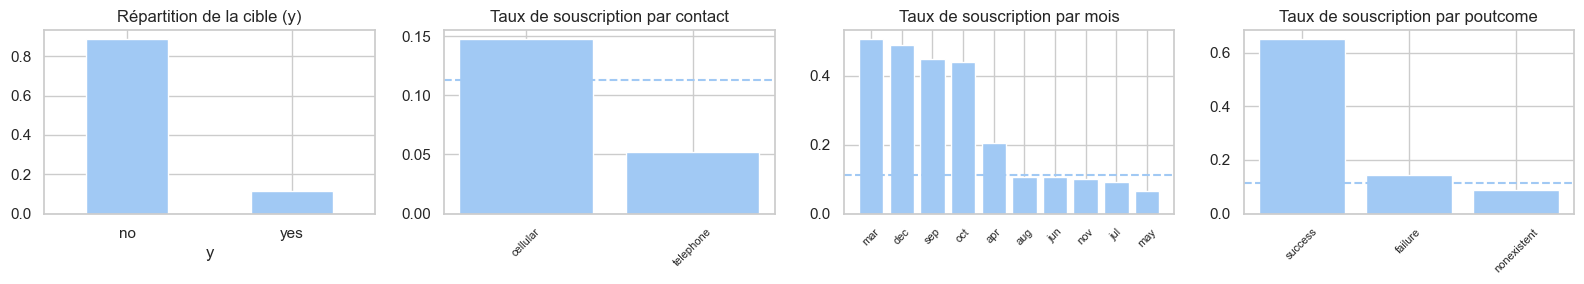

In [20]:
base_rate = df['y_bin'].mean()
print(f"\nTaux de 'yes' (base rate) = {base_rate:.3f}")

fig, axes = plt.subplots(1, 4, figsize=(16, 3))

# 1) Répartition de la cible
ax = axes[0]
(df['y']
 .value_counts(normalize=True)
 .plot(kind='bar', ax=ax))
ax.set_title("Répartition de la cible (y)")
ax.tick_params(axis='x', labelrotation=0)

# 2) Taux par contact
if 'contact' in df.columns:
    t = df.groupby('contact')['y_bin'].mean().sort_values(ascending=False)
    ax = axes[1]
    ax.bar(t.index.astype(str), t.values)
    ax.axhline(base_rate, linestyle='--')
    ax.set_title("Taux de souscription par contact")
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)

# 3) Taux par mois
if 'month' in df.columns:
    t = df.groupby('month')['y_bin'].mean().sort_values(ascending=False)
    ax = axes[2]
    ax.bar(t.index.astype(str), t.values)
    ax.axhline(base_rate, linestyle='--')
    ax.set_title("Taux de souscription par mois")
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)

# 4) Taux par poutcome
if 'poutcome' in df.columns:
    t = df.groupby('poutcome')['y_bin'].mean().sort_values(ascending=False)
    ax = axes[3]
    ax.bar(t.index.astype(str), t.values)
    ax.axhline(base_rate, linestyle='--')
    ax.set_title("Taux de souscription par poutcome")
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)

plt.tight_layout()
plt.show()


La distribution de la cible est très déséquilibrée :

- seulement **11,3 %** des clients souscrivent (`y = yes`),  
- contre **88,7 %** qui ne souscrivent pas.

---

##  Visualisations clés

Les graphiques confirment des écarts très marqués selon certaines variables :

- **Contact :**  
  - `cellular` → taux beaucoup plus élevé que la moyenne  
  - `telephone` → taux très faible  
  → variable très discriminante

- **Month :**  
  - Mai (may) et novembre (nov) affichent les meilleurs taux  
  - Mars–août ont des taux très faibles  
  → forte saisonnalité commerciale

- **Poutcome :**  
  - `success` → taux exceptionnellement élevé  
  - `failure` et `nonexistent` → nettement en dessous  
  → variable la plus informative du dataset

Ces graphes sont particulièrement utiles pour repérer les biais structurels du dataset.

---

##  Importance du déséquilibre pour la modélisation

Ce déséquilibre fort implique que :

- un modèle naïf prédirait “no” dans presque tous les cas,  
- les métriques classiques (accuracy) seront trompeuses,  
- il faudra utiliser :  
  → *ponderation des classes*,  
  → *focal loss*,  
  → *oversampling (SMOTE)* ou  
  → *évaluation au log-loss / AUC*.

Le déséquilibre introduit également un **biais comportemental** :  
le dataset reflète une campagne où le taux de conversion est structurellement très faible.


##  Synthèse — Interprétation & préparation à la modélisation

** Variables les plus pertinentes pour expliquer la cible**

Les analyses univariées et bivariées montrent que les variables les plus discriminantes sont :

- **poutcome** (résultat de campagnes précédentes) — extrêmement informatif  
- **month** (saisonnalité commerciale)  
- **contact** (canal utilisé)  
- **job**, **education**, **marital** (profils socio-démographiques)  
- **previous** (historique d’interactions)  
- **cons.conf** (confiance)
- **duration** (mais à exclure du modèle car fuite d’information)

Les variables macroéconomiques (`emp.var.rate`, `euribor3m`, etc.) capturent un **effet temporel**, à surveiller selon le split temporel choisi.

---

** Biais ou déséquilibres présents**

- **Très fort déséquilibre de classe** : 11 % de “yes”.  
- **Catégories ultra-dominantes** :  
  - `pdays = 999` (= jamais contacté)  
  - `poutcome = nonexistent`  
  - `marital = married`, `contact = cellular`  
- Certaines variables sont **peu informatives** car quasi constantes (`default`, `loan`, `housing`).
- La variable `duration` incorpore une **fuite d’information** : elle dépend du résultat de l’appel.

---

** Graphiques / indicateurs les plus informatifs**

- **Heatmaps de corrélation** : révèlent les blocs temporels macroéconomiques.  
- **Taux de souscription par catégorie (barplots)** : identifient clairement les variables les plus discriminantes.  
- **Lift maximal par variable catégorielle** : excellent indicateur de puissance prédictive.  
- **Distribution de la cible (`y`)** : met en évidence le fort déséquilibre.  
- **Boxplots numériques selon catégorie** : montrent les liens socio-démographiques (job, éducation → age, duration).  
- **Analyse de `pdays`** : révèle un code métier (999 → jamais contacté).

Ces éléments donnent une vision claire des facteurs déterminants et des biais structurels du dataset, et orientent la préparation du pipeline de modélisation.
